In [1]:

import cartopy.crs as ccrs
import os

import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import configparser
import json


import modules.load_data as ld
from modules.modules_FIG_08_10_11 import *

stations= ld.dwd_stations()
stations = stations.where(stations.station!='ZG',drop=True)

config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']








def make_plot1(fig,ax,x,y,data,data2=None,title='',
              clabel='',cmap='autumn_r',cborientation='vertical',cbaxextend=[],
              cbpanchor=False,cbspacing='proportional',
              cb=True,cbarres=2,cbticks=None,cbaspect=20,
              data2res=2,data2ticks=None):
    # make subplot

    ax.set_title(title,fontsize=14)
    
    # plot map
    fig,ax = make_map(fig,ax)
   
    if type(cbticks)==type(None):
        # make contourplot
        ticks = np.arange(np.round(np.nanpercentile(data,1),cbarres)-10**(-cbarres),
                          np.round(np.nanpercentile(data,99),cbarres)+10**(-cbarres),10**(-cbarres))
        while len(ticks)>11:
            ticks = ticks[::2]
    else:
        ticks=cbticks
    p1=ax.contourf(x,y,data,transform=ccrs.PlateCarree(),cmap=cmap,vmin=np.min(ticks),vmax=np.max(ticks),
                   levels = ticks)
    
    if type(data2)!=type(None):
        if type(data2ticks)==type(None):
            # make contourplot
            ticks2 = np.arange(np.round(np.nanpercentile(data2,1),data2res),
                               np.round(np.nanpercentile(data2,99),data2res),10**(-data2res))
            while len(ticks2)>11:
                ticks2 = ticks2[::2]
        else:
            ticks2=data2ticks
        
        CS=ax.contour(x,y,data2,transform=ccrs.PlateCarree(),levels=ticks2,colors=['k']*len(ticks2))
        ax.clabel(CS, inline=1, fontsize=14)
    
    if cb:
        cbaxes = ax
        if len(cbaxextend)>0:
            cbaxes = [ax]+cbaxextend
        if type(cbpanchor)==type(bool):
            cb = plt.colorbar(p1,ax=cbaxes,ticks=ticks,
                              orientation=cborientation,
                              aspect=cbaspect,
                              spacing=cbspacing,pad=0.05,shrink=0.9)
        else:
            cb = plt.colorbar(p1,ax=cbaxes,ticks=ticks,
                              orientation=cborientation,
                              panchor=cbpanchor,
                              aspect=cbaspect,
                              spacing=cbspacing,pad=0.05,shrink=0.9)
        cb.ax.set_title(clabel,loc='left')
    fig.canvas.draw()
    return fig, ax

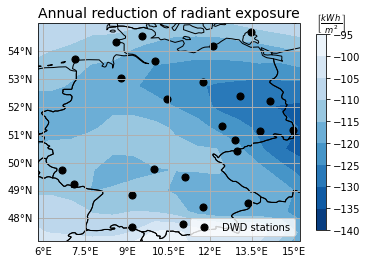

In [2]:
ECRAD = xr.open_dataset(os.path.join(pf,"TCARS.nc"))
# bias correction see FIG5 
ECRAD.REari_sfc.values = ECRAD.REari_sfc.values+1.5
ECRAD.REari_toa.values = ECRAD.REari_toa.values-0.6
Eyear = ECRAD.mean(dim='day')

Etotal = Eyear.GLO0.values*24.*365*1e-3
Ereduc = (Eyear.GLO-Eyear.GLO0).values*24.*365*1e-3
Erel = 100.*Ereduc/Etotal

fig = plt.figure()
ax = plt.subplot(111,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Ereduc,cmap='Blues_r',
                     cbticks=np.arange(-140,-90,5),
                     clabel=r"$\left[\frac{kW\,h}{m^{2}}\right]$",
                     title=r'Annual reduction of radiant exposure')

ax.scatter(stations.longitude,stations.latitude,
           s = 50,c='k',
           transform=ccrs.PlateCarree(), label='DWD stations')

plt.legend()
plt.savefig("figures/EGU_irradiance_reduction.png",dpi=300,bbox_inches='tight')

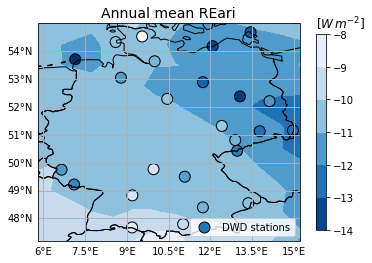

In [3]:
models = np.array([
                   'MRM61',
                   'ESRA',
                   'Heliosat1I',
                   'SOLISsimple',
                   'CEM',
                   'MMAC',
                   'METSTAT',
                  ])
ECRAD = xr.open_dataset(os.path.join(pf,"TCARS.nc"))
# bias correction see FIG5 
ECRAD.REari_sfc.values = ECRAD.REari_sfc.values+1.5
ECRAD.REari_toa.values = ECRAD.REari_toa.values-0.6

ECDWD = xr.open_dataset(os.path.join(pf,"REari_TCARS2DWD.nc"))
# bias correction
ECDWD.REari_sfc.values = ECDWD.REari_sfc.values+1.5
ECDWD.REari_toa.values = ECDWD.REari_toa.values-0.6

DWD = xr.open_dataset(os.path.join(pf,"REari_CSF2DWD.nc"))
DWD = DWD.where(DWD.station!='ZG',drop=True)


Eyear = ECRAD.mean(dim='day')


# ECRAD on DWD stations
ECDWD_sfc = np.zeros((len(ECRAD.day),len(DWD.station),len(DWD.model)))*np.nan
ECDWD_toa = np.zeros((len(ECRAD.day),len(DWD.station),len(DWD.model)))*np.nan
coords = dict(day = ECDWD.day,
              station = DWD.station,
              model = DWD.model)
for s,station in enumerate(stations.station.values):
    st = stations.sel(station=station)
#     EC = ECRAD.interp(lat=st.latitude.values,lon=st.longitude.values)
    EC = ECDWD.sel(station=station)
    for m,model in enumerate(models):
        ARE = DWD.ARE_csf.sel(station=station,model=model)
        ARE[ARE>=0]=np.nan
        idx = ~np.isnan(ARE.values)*~np.isnan(EC.REari_sfc.values)
        ECDWD_sfc[:,s,m] = EC.REari_sfc.where(idx)
        ECDWD_toa[:,s,m] = EC.REari_toa.where(idx)

ECDWD = xr.Dataset({'ARE_sfc':(('day','station','model'),ECDWD_sfc),
                    'ARE_toa':(('day','station','model'),ECDWD_toa)},
                   coords=coords)


EDWDyear = ECDWD.sel(model='ESRA').interpolate_na(dim='day').mean(dim=['day'],skipna=True)

vmin=-14
vmax=-8
vstep=1

fig = plt.figure()
ax = plt.subplot(111,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,
                     Eyear.REari_sfc,cmap='Blues_r',
                     cbticks=np.arange(vmin,vmax+vstep,vstep),
                     clabel=r"$\left[W\,m^{-2}\right]$",
                     title=r'Annual mean REari')


ax.scatter(stations.longitude,stations.latitude,
           s = 120,
           c = EDWDyear.ARE_sfc.values,
           vmin=vmin,vmax=vmax,
           cmap='Blues_r',
           edgecolors = 'k',
          transform=ccrs.PlateCarree(), label='DWD stations')

plt.legend()
plt.savefig("figures/EGU_REari_map.png",dpi=300,bbox_inches='tight')

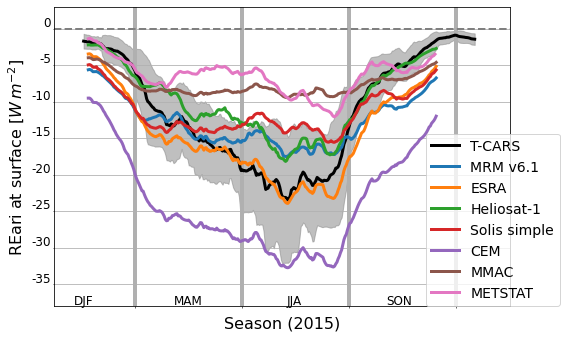

In [4]:
models = np.array([
                   'MRM61',
                   'ESRA',
                   'Heliosat1I',
                   'SOLISsimple',
                   'CEM',
                   'MMAC',
                   'METSTAT',
                  ])

models_label = np.array([
                         'MRM v6.1',
                         'ESRA',
                         'Heliosat-1',
                         'Solis simple',
                         'CEM',
                         'MMAC',
                         'METSTAT',
 
                        ])
plt.figure(figsize=(8,4.8))#figsize=(8,5)

# EARE = xr.DataArray(np.median(ECRAD.REari_sfc,axis=[1,2]),dims={'day':ECRAD.day})
ECDWD = xr.open_dataset(os.path.join(pf,"REari_TCARS2DWD.nc"))
# bias correction
ECDWD.REari_sfc.values = ECDWD.REari_sfc.values+1.5
ECDWD.REari_toa.values = ECDWD.REari_toa.values-0.6

EARE = ECDWD.REari_sfc.mean(dim='station',skipna=True)

ARE = EARE.rolling(day=30,center=True).mean()
dARE = EARE.rolling(day=30,center=True).std()
plt.fill_between(np.arange(len(ECRAD.day)),ARE-dARE,ARE+dARE,color=(0.5,0.5,0.5),alpha=0.5)
plt.plot(np.arange(len(ECRAD.day)),ARE,color='k',linewidth=3,label='T-CARS')


for m,model in enumerate(zip(models,models_label)):
    model,mlabel=model
    ARE = DWD.ARE_csf.sel(model=model).mean(dim='station',skipna=True).interpolate_na(dim='day').rolling(day=30,center=True).mean(skipna=True)

    plt.plot(ARE,linestyle='-',linewidth=3,label = mlabel)

plt.axhline(0,linestyle='--',linewidth=2,color=(0.5,0.5,0.5))

# plt.ylim([-80,0])    
plt.legend(fontsize=14,bbox_to_anchor=(0.8, 0.6))#bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
ax=plt.gca()
ax.set_xlim([-10,380])
ax.set_ylim([-38,3])
# config axis labels
ax.set_xticks(np.linspace(15,285,4))
ax.set_yticks(np.arange(-35,5,5)+1)
ax.set_xticklabels(['DJF','MAM','JJA','SON'])#,fontweight='bold')
ax.set_yticklabels(np.arange(-35,5,5),fontsize=10)
ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
# config for gridlines
ax.set_xticks(np.linspace(59,334,4),minor=True)
ax.set_yticks(np.arange(-35,5,5),minor = True)
ax.grid(which='minor')
ax.tick_params('x',which='minor',grid_linewidth=4)
ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
ax.set_xlabel('Season (2015)',fontsize=16)#,fontweight='bold')


plt.ylabel(r'REari at surface $\left[W\,m^{-2}\right]$',fontsize=16)#,fontweight='bold')
plt.tight_layout()
plt.savefig('figures/EGU_REari_overview.png',dpi=300,bbox_inches='tight')